In [17]:
from dgl.data import citation_graph as citegrh
import dgl
import dgl.function as fn
import torch as th
import torch.nn as nn
import torch.nn.functional as F
from dgl import DGLGraph
import networkx as nx
import numpy as np
import itertools

#Load the cora dataset
def load_cora_data():
    data = citegrh.load_cora()
    features = th.FloatTensor(data.features)
    labels = th.LongTensor(data.labels)
    mask = th.ByteTensor(data.train_mask)
    g = DGLGraph(data.graph)
    return g, features, labels, mask
g, features, labels, mask = load_cora_data()


Finished data loading and preprocessing.
  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000


In [18]:
# We first validate that in CORA, intra community connections
# are more than inter community connections

g_nx = g.to_networkx(g)
adj = nx.adjacency_matrix(g_nx).todense()
class_to_intra_prob = {i: 0 for i in range(7)}
class_to_total = {i: 0 for i in range(7)}
class_to_intra_sum = {i: 0 for i in range(7)}
for i in range(g_nx.number_of_nodes()):
    _, index = np.where(adj[i] !=0)
    each_total = len(index)
    intra_num = 0
    for j in index:
        if labels[i] == labels[j]:
            intra_num += 1
    class_to_total[int(labels[i])] += each_total
    class_to_intra_sum[int(labels[i])] += intra_num
for i in range(7):
    class_to_intra_prob[i] = class_to_intra_sum[i] / class_to_total[i]
        
    
    
    
    
print(class_to_intra_prob)

/data/huangqi/dgl2/dgl/python/dgl/graph.py:657: UserWarning: to_networkx currently does not support converting node/edge features automatically.
  dgl_warning('to_networkx currently does not support converting'


{0: 0.6994106090373281, 1: 0.7949465500485908, 2: 0.9058050383351588, 3: 0.8280479210711769, 4: 0.8291457286432161, 5: 0.7679558011049724, 6: 0.7689969604863222}


In [38]:
import matplotlib.pyplot as plt
%matplotlib inline
#CORA visualization tool
def cora_viz(labels,subgraph):
    value = [labels[node] for node in subgraph.nodes()]
    pos = nx.spring_layout(subgraph, random_state=1)
    nx.draw_networkx(subgraph, 
                     pos=pos, 
                     edge_color='k', 
                     node_size=5, 
                     cmap=plt.get_cmap('Set2'), 
                     node_color=value,
                     with_labels=False)   
    #plt.show()
cora_viz(labels,g)
plt.show()

KeyboardInterrupt: 

In [20]:
# re-write the dataset into Dataloader
from dgl.utils import Index
from dgl.batched_graph import batch
class CORABinary:
    """
    Simple binary subgraph constrcutor for CORA.
    Should be able to be used to extract binary 
    subgraph from other graph dataset.
    
    Parameters
    ----------
    
    g : DGLGraph object
        the graph
    features : numpy ndarray
        features of nodes
    labels : numpy ndarray
        labels of nodes
    num_classes : int
        number of classes at interest
    """
    
    def __init__(self, g, features, labels, num_classes):
        self._g = g
        self._features = features
        self._labels = labels
        self._n_classes = num_classes
        self._community_to_node = [[] for i in range(max(labels)+1)]
        for node in range(len(labels)):
            self._community_to_node[labels[node]].append(node)
        self._g_nx = g.to_networkx()
        self._subgraphs = []
        self._subfeatures = []
        self._sublabels = []
        
        for i,j in itertools.combinations([i for i in range(num_classes)],2):
            subgraph, new2oldindex = self.binary_subgraph_cora(self._g_nx, 
                                                               self._community_to_node, 
                                                               i, 
                                                               j)
            subfeature = self._features[list(subgraph.nodes()),:]
            sublabel = self._labels[list(new2oldindex[i] 
                                   for i in subgraph.nodes())]
            #relabel the subgraph
            sublabel[sublabel<=i] = 0
            sublabel[sublabel>i] = 1
            self._subgraphs.append(DGLGraph(subgraph))
            #/TODO: directly build DGL subgraph
            self._subfeatures.append(subfeature)
            self._sublabels.append(sublabel)
        
        
        #Contruct line graph
        
        self._line_graphs = [g.line_graph(backtracking=False) 
                             for g in self._subgraphs]
        in_degrees = lambda g: g.in_degrees(
                             Index(th.arange(0, g.number_of_nodes()))).unsqueeze(1).float()
        #TODO : replace th.arange to F.arange when migrating back to /data
        
        self._g_degs = [in_degrees(g) for g in self._subgraphs]
        self._lg_degs = [in_degrees(lg) for lg in self._line_graphs]
        self._pm_pds = list(zip(*[g.edges() for g in self._subgraphs]))[0]
        
        self._equi_labels = []
        for label in self._sublabels:
            mirror_label = th.ones(label.shape).long() - label
            self._equi_labels.append(mirror_label)
    
    def binary_subgraph_cora(self,
                             original_graph, 
                             community_to_node, 
                             classA=0, 
                             classB=1):
        sub = nx.DiGraph(original_graph.subgraph(community_to_node[classA]+
                                                 community_to_node[classB]))
        #cast to undirected graph to find connected component
        sub_und = nx.Graph(sub)
        candidate_edge_list = []
        for edge in sub.edges():
            # Only look at src node of edges that cross communities
            if (labels[edge[0]] != labels[edge[1]]):
                candidate_edge_list.append(edge)
        component_list = []
        for edge in candidate_edge_list:
            component_list.append(
                nx.node_connected_component(sub_und,edge[0]))
        component_list.sort(key=len, reverse=True)
        
        # find the largest connected component to be the candidate subgraph
        largest_subgraph = component_list[0]
        old2newindex = {}
        new2oldindex = {}
        reindex_nodes = [i for i in range(len(largest_subgraph))]
        reindex_edges = []
        for i, node in enumerate(largest_subgraph):
            old2newindex[node] = i
            new2oldindex[i] = node
        for src,dst in sub.edges(largest_subgraph):
            reindex_edges.append((old2newindex[src], old2newindex[dst]))

        #use old2newindex to manually reindex the subgraph
        #/TODO(hq): send nodelist directly to DGLgraph
        reindex_graph = nx.DiGraph()
        reindex_graph.add_nodes_from(reindex_nodes)
        reindex_graph.add_edges_from(reindex_edges)


        return reindex_graph, new2oldindex
    
    def __len__(self):
        return len(self._subgraphs)
    
    def __getitem__(self, idx):
        return self._subgraphs[idx], self._line_graphs[idx], self._g_degs[idx], self._lg_degs[idx], self._pm_pds[idx], self._subfeatures[idx], self._sublabels[idx], self._equi_labels[idx]
    
    def collate_fn(self, x):
        subgraph, line_graph, deg_g, deg_lg, pm_pd, subfeature, sublabel, equi_label = zip(*x)
        subgraph_batch = batch(subgraph)
        line_graph_batch = batch(line_graph)
        # TODO : change to F.cat when migrating to /data
        deg_g_batch = th.cat(deg_g, dim=0)
        deg_lg_batch = th.cat(deg_lg, dim=0)
        
        self.total = 0
        def offset(pm_pd):
            prev_total = self.total
            self.total += pm_pd.size(0)
            return prev_total
        pm_pd_batch = th.cat([x + offset(x) for i, x in enumerate(pm_pd)], 
                             dim=0)
        
        subfeature_batch = th.cat(subfeature, dim=0)
        sublabel_batch = th.cat(sublabel, dim=0)
        equilabel_batch = th.cat(equi_label, dim=0)
        
        return subgraph_batch, line_graph_batch, deg_g_batch, deg_lg_batch, pm_pd_batch,subfeature_batch, sublabel_batch, equilabel_batch    
        
        
    
    
        

In [21]:
# --------------------Model--------------------------------
class GNNModule(nn.Module):
    def __init__(self, in_feats, in_y_feats, out_feats, radius):
        super().__init__()
        self.out_feats = out_feats
        self.radius = radius

        new_linear = lambda: nn.Linear(in_feats, out_feats)
        new_linear_list = lambda: nn.ModuleList([new_linear() for i in range(radius)])
        
        new_linear_y = lambda: nn.Linear(in_y_feats, out_feats)
        new_linear_list_y = lambda: nn.ModuleList([new_linear_y() for i in range(radius)])
        self.theta_x, self.theta_deg = \
            new_linear(), new_linear()
        self.theta_y = new_linear_y()
        self.theta_list = new_linear_list()

        self.gamma_deg, self.gamma_x = \
            new_linear(), new_linear()
        self.gamma_y = new_linear_y()
        self.gamma_list = new_linear_list_y()

        self.bn_x = nn.BatchNorm1d(out_feats)
        self.bn_y = nn.BatchNorm1d(out_feats)

    def aggregate(self, g, z):
        z_list = []
        g.set_n_repr({'z' : z})
        g.update_all(fn.copy_src(src='z', out='m'), fn.sum(msg='m', out='z'))
        z_list.append(g.get_n_repr()['z'])
        for i in range(self.radius - 1):
            for j in range(2 ** i):
                g.update_all(fn.copy_src(src='z', out='m'), fn.sum(msg='m', out='z'))
            z_list.append(g.get_n_repr()['z'])
        return z_list

    def forward(self, g, lg, x, y, deg_g, deg_lg, pm_pd):
        pmpd_x = F.embedding(pm_pd, x)

        sum_x = sum(theta(z) for theta, z in zip(self.theta_list, self.aggregate(g, x)))
        
        g.set_e_repr({'y' : y})
        g.update_all(fn.copy_edge(edge='y', out='m'), fn.sum('m', 'pmpd_y'))
        pmpd_y = g.pop_n_repr('pmpd_y')

        x = self.theta_x(x) + self.theta_deg(deg_g * x) + sum_x + self.theta_y(pmpd_y)
        n = self.out_feats // 2
        x = th.cat([x[:, :n], F.relu(x[:, n:])], 1)
        x = self.bn_x(x)

        sum_y = sum(gamma(z) for gamma, z in zip(self.gamma_list, self.aggregate(lg, y)))
        y = self.gamma_y(y)
        
        y = th.cat([y[:, :n], F.relu(y[:, n:])], 1)
        y = self.bn_y(y)

        return x, y

class GNN(nn.Module):
    def __init__(self, feats, radius, n_classes):
        """
        Parameters
        ----------
        g : networkx.DiGraph
        """
        super(GNN, self).__init__()
        self.linear = nn.Linear(feats[-1], n_classes)
        self.y_feats = [1] + feats[1:]
        self.module_list = nn.ModuleList([GNNModule(m, m_y, n, radius)
                                          for m, m_y, n in zip(feats[:-1],self.y_feats[:-1], feats[1:])])

    def forward(self, g, lg, deg_g, deg_lg, pm_pd, feature):
        x, y = feature, deg_lg
        for module in self.module_list:
            x, y = module(g, lg, x, y, deg_g, deg_lg, pm_pd)
            #print("pass")
        return self.linear(x)

In [22]:
def accuracy(z_list, labels):
    accu = []
    ybar_list = [th.max(z, 1)[1] for z in z_list]
    for y_bar in ybar_list:
        accuracy = max(th.sum(y_bar == label).item() for label in labels) / len(labels[0])
        accu.append(accuracy)
    return sum(accu) / len(accu)



In [23]:
import time
def step(i, j, g, lg, deg_g, deg_lg, pm_pd, feature, label, equi_label, n_batchsize):
    """ One step of training. """
    #print(feature.shape)
    t0 = time.time()
    z = model(g, lg, deg_g, deg_lg, pm_pd, feature)
    time_forward = time.time() - t0

    #Assume z one at a time
    #z_list = [z]
    z_list = th.chunk(z, n_batchsize, 0)
    #n_batchsize = 1 # Modus vivendi
    equi_labels = [label, equi_label]
    loss = sum(min(F.cross_entropy(z, y) for y in equi_labels) for z in z_list) / n_batchsize
    #overlap = compute_overlap(z_list)
    
    accu = accuracy(z_list, equi_labels)

    optimizer.zero_grad()
    t0 = time.time()
    loss.backward()
    time_backward = time.time() - t0
    optimizer.step()

    return loss, accu, time_forward, time_backward

In [24]:
def val(g, lg, deg_g, deg_lg, pm_pd, feature, label, equi_label):
    z = model(g, lg, deg_g, deg_lg, pm_pd, feature)
    
    z_list = [z]
    #z_list = th.chunk(z, n_batchsize, 0)
    
    #n_batchsize = 1
    
    equi_labels = [label, equi_label]
    
    accu = accuracy(z_list, equi_labels)
    
    return accu

In [25]:
def inference_viz(g, lg, deg_g, deg_lg, pm_pd, feature):
    z = model(g, lg, deg_g, deg_lg, pm_pd, feature)
    
    z_list = [z]
    
    n_batchsize = 1
    ybar_list = [th.max(z, 1)[1] for z in z_list]
    cora_viz(ybar_list[0],g.to_networkx())

In [26]:
import torch.optim as optim
n_features = 16
n_layers = 10
radius = 2
lr = 1e-2
K = 2 # num_of_classes
feats = [features.shape[1]] + [n_features]*n_layers + [K]
model = GNN(feats, radius, K)

optimizer = optim.Adam(model.parameters(), lr=lr)

In [27]:
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
n_batch_size = 1
split = 20

training_dataset = CORABinary(g, features, labels, num_classes=7)
num_train = len(training_dataset)
print("num_train is", num_train)
indices = list(range(num_train))
validation_idx = np.random.choice(indices, size=1)
print("the selection is", validation_idx)
validation_sampler = SubsetRandomSampler(validation_idx)
training_loader = DataLoader(training_dataset, 
                             n_batch_size,
                             collate_fn=training_dataset.collate_fn, 
                             drop_last=True)
validation_loader = DataLoader(training_dataset,
                     n_batch_size,
                     collate_fn = training_dataset.collate_fn,
                     sampler=validation_sampler)

/data/huangqi/dgl2/dgl/python/dgl/graph.py:657: UserWarning: to_networkx currently does not support converting node/edge features automatically.
  dgl_warning('to_networkx currently does not support converting'


num_train is 21
the selection is [7]


average loss for epoch 0 is 0.6437472701072693, with avg accu 0.6557795248430668
average loss for epoch 1 is 0.5261824727058411, with avg accu 0.7724648297119296
average loss for epoch 2 is 0.4943006932735443, with avg accu 0.7731806694433762
average loss for epoch 3 is 0.45035049319267273, with avg accu 0.7938655953709266
average loss for epoch 4 is 0.42047446966171265, with avg accu 0.8111939179859261
average loss for epoch 5 is 0.40100064873695374, with avg accu 0.8270477895122605
average loss for epoch 6 is 0.45962464809417725, with avg accu 0.7874516280297014
average loss for epoch 7 is 0.40433192253112793, with avg accu 0.8367031756178521
average loss for epoch 8 is 0.40141236782073975, with avg accu 0.8395584357394339
average loss for epoch 9 is 0.38217848539352417, with avg accu 0.8423501565842432
validating...
#########
validation accu 0.7776470588235294
#########


/data/huangqi/dgl2/dgl/python/dgl/graph.py:657: UserWarning: to_networkx currently does not support converting node/edge features automatically.
  dgl_warning('to_networkx currently does not support converting'


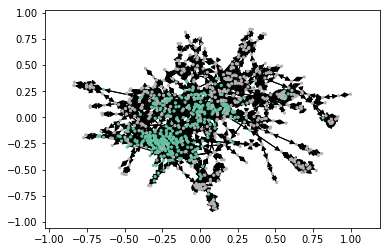

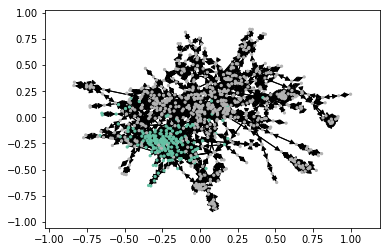

In [28]:
#main loop



n_iterations = 20
n_epochs = 10
validation_example_label_change = []

for i in range(n_epochs):
    total_loss, total_accu, s_forward, s_backward = 0, 0, 0, 0
    for j, [g, lg, g_deg, lg_deg, pm_pd, subfeature, label, equivariant_label] in enumerate(training_loader):
        loss, accu, t_forward, t_backward = step(i,
                                                 j,
                                                 g,
                                                 lg,
                                                 g_deg,
                                                 lg_deg,
                                                 pm_pd,
                                                 subfeature,
                                                 label,
                                                 equivariant_label,
                                                 n_batch_size)
        total_loss += loss
        s_forward += t_forward
        s_backward += t_backward
        total_accu += accu
    
    print("average loss for epoch {} is {}, with avg accu {}".format(i, total_loss/len(training_loader), total_accu/len(training_loader)))
    [g, lg, g_deg, lg_deg, pm_pd, subfeature, label, equi_label] = next(iter(validation_loader))
    
    z = model(g, lg, g_deg, lg_deg, pm_pd, subfeature)
    validation_example_label_change.append(th.max(z, 1)[1])
    #inference_viz(g,
    #              lg,
    #              g_deg,
    #              lg_deg,
    #              pm_pd,
    #              subfeature)
    
    #print("validating...")
    #for k in range(len(gs) - split):
    #    accu = val(gs[split+k], 
    #               lgs[split+k], 
    #               g_degs[split+k], 
    #               lg_degs[split+k], 
    #               pm_pds[split+k], 
    #               subfeatures[split+k], 
    #               equivariant_labels[split+k])
    #    print("#########")
    #    print("validation accu {}".format(accu))
    #    print("#########")
    
    
    
print("validating...")
for k in range(len(training_loader) - split):
    [g, lg, g_deg, lg_deg, pm_pd, subfeature, label, equi_label] = next(iter(validation_loader))
    #print(g.nodes())
    accu = val(g, 
               lg, 
               g_deg, 
               lg_deg, 
               pm_pd, 
               subfeature,
               label,
               equi_label)
    print("#########")
    print("validation accu {}".format(accu))
    print("#########")
    inference_viz(g,
                  lg,
                  g_deg,
                  lg_deg,
                  pm_pd,
                  subfeature)
    plt.show()
    cora_viz(label, g.to_networkx())
    plt.show()



In [29]:
x = th.ones(3)
y = th.ones(4)
th.cat([x, y])

tensor([1., 1., 1., 1., 1., 1., 1.])

In [30]:
import matplotlib.animation as animation
%matplotlib notebook

In [35]:
def cora_viz_ani(labels,subgraph):
    value = [labels[node] for node in subgraph.nodes()]
    pos = nx.spring_layout(subgraph, random_state=1)
    nx.draw_networkx(subgraph, 
                     pos=pos, 
                     edge_color='k', 
                     node_size=5, 
                     cmap=plt.get_cmap('Set2'), 
                     node_color=value,
                     with_labels=False)   

<IPython.core.display.Javascript object>


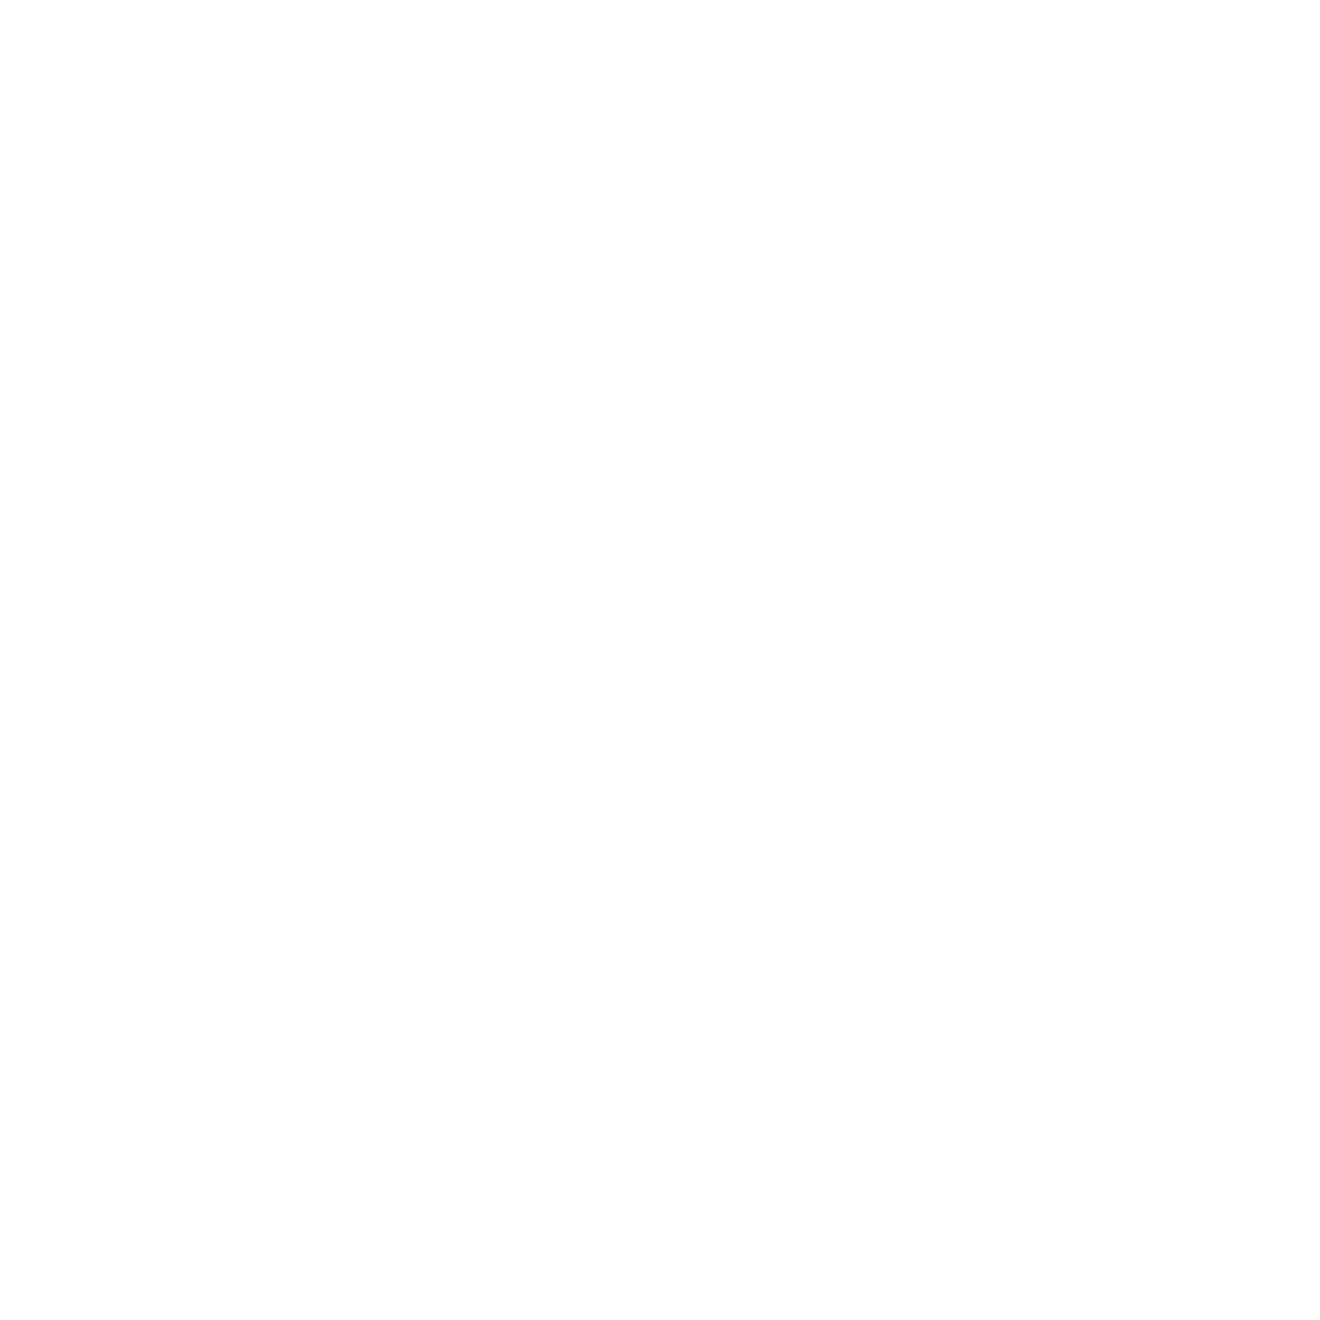

/data/huangqi/dgl2/dgl/python/dgl/graph.py:657: UserWarning: to_networkx currently does not support converting node/edge features automatically.
  dgl_warning('to_networkx currently does not support converting'


<IPython.core.display.Javascript object>


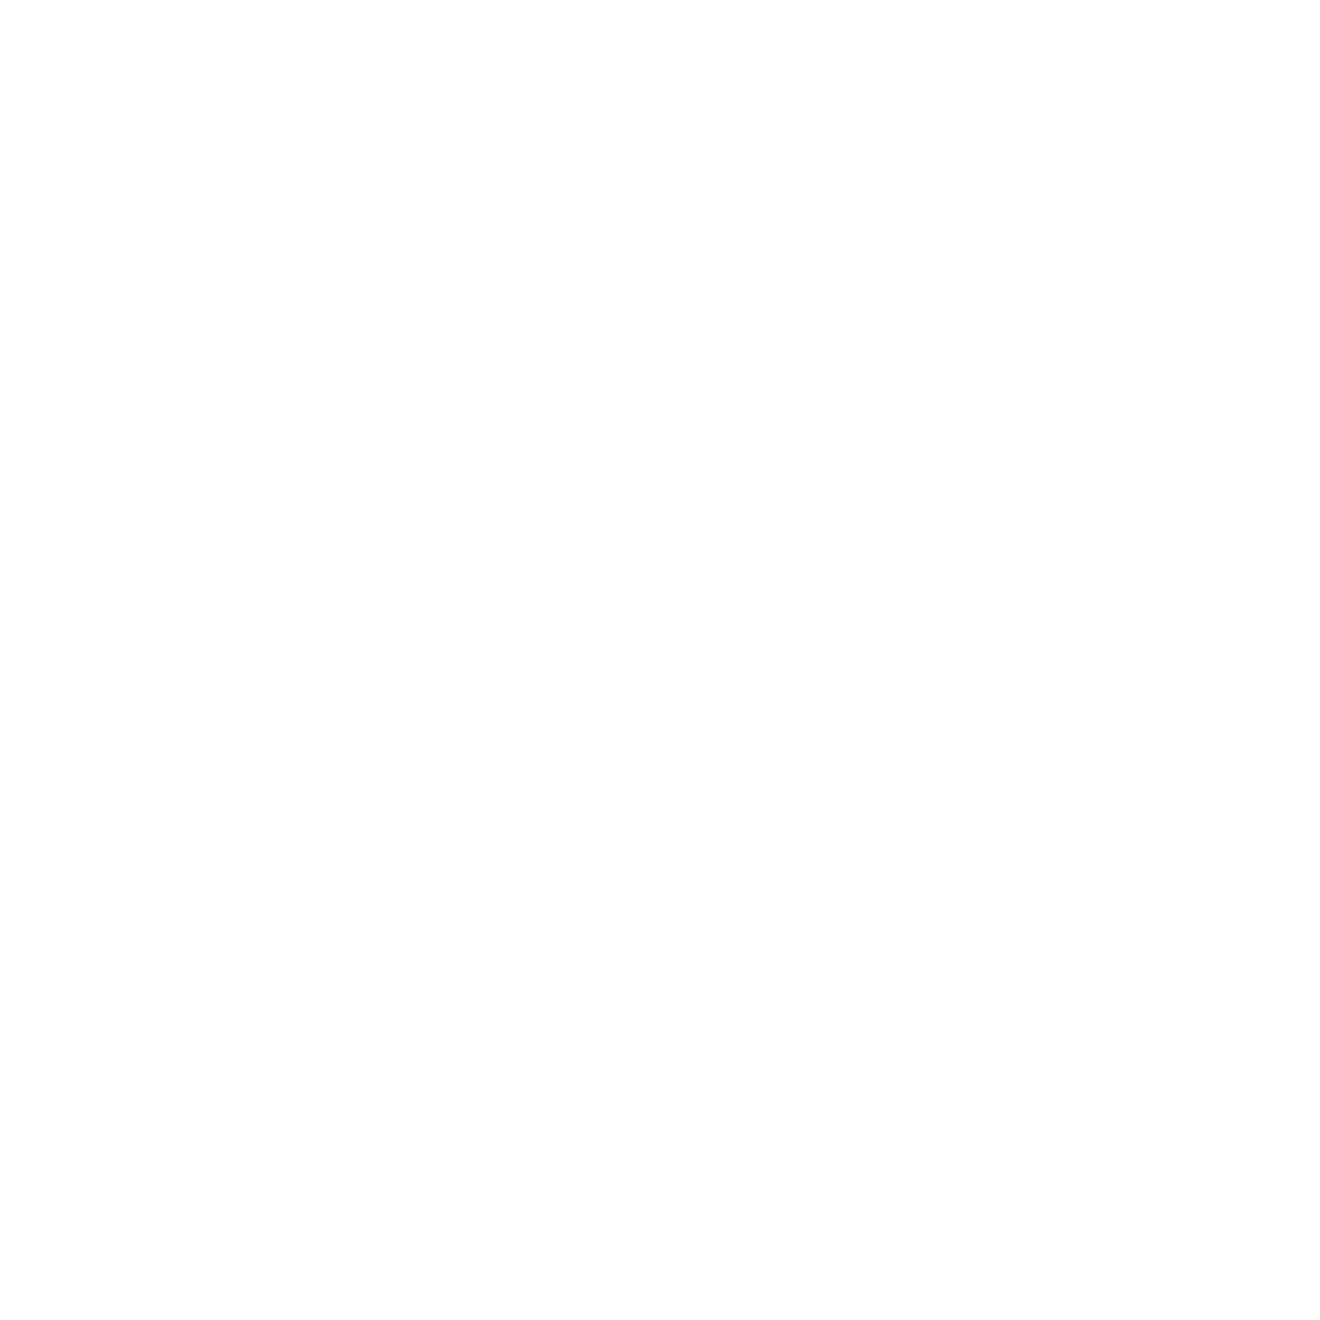

Traceback (most recent call last):
  File "/data/huangqi/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py", line 388, in process
    proxy(*args, **kwargs)
  File "/data/huangqi/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py", line 228, in __call__
    return mtd(*args, **kwargs)
  File "/data/huangqi/anaconda3/lib/python3.6/site-packages/matplotlib/animation.py", line 1499, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


In [37]:
fig2 = plt.figure(figsize=(8,8), dpi=150)
fig2.clf()
ax = fig2.subplots()
[g, lg, g_deg, lg_deg, pm_pd, subfeature, label, equi_label] = next(iter(validation_loader))
g_nx = g.to_networkx()
pos = nx.spring_layout(g_nx, random_state=1)

def classify_animate(i):
    #print("activated! %d" % i)
    ax.cla()
    ax.axis('off')
    ax.set_title("community detection result @ epoch %d" % i)
    value = [validation_example_label_change[i][node] for node in g_nx.nodes()]
    nx.draw_networkx(g_nx,
                     pos=pos,
                     edge_color='k',
                     node_size=7,
                     cmap=plt.get_cmap('Set2'),
                     node_color=value,
                     arrows=False,
                     width=0.6,
                     with_labels=False)
    

ani = animation.FuncAnimation(fig2, classify_animate, frames=len(validation_example_label_change), interval=500)
ani.save('./animationnew2.gif', writer='imagemagick')
plt.show()

/data/huangqi/dgl2/dgl/python/dgl/graph.py:657: UserWarning: to_networkx currently does not support converting node/edge features automatically.
  dgl_warning('to_networkx currently does not support converting'


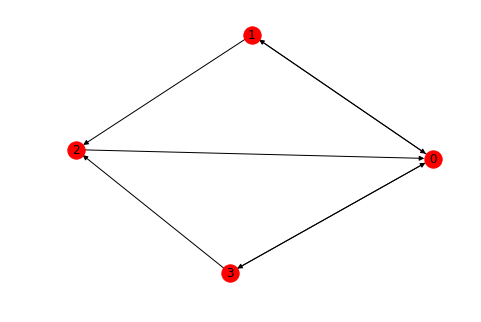

In [39]:
toygraph = DGLGraph()
toygraph.add_nodes(4)
toygraph.add_edges([0,1,1,0,3,3,2],[1,0,2,3,2,0,0])
nx.draw(toygraph.to_networkx(), with_labels=True)
lg = toygraph.line_graph(backtracking=False)


/data/huangqi/dgl2/dgl/python/dgl/graph.py:657: UserWarning: to_networkx currently does not support converting node/edge features automatically.
  dgl_warning('to_networkx currently does not support converting'


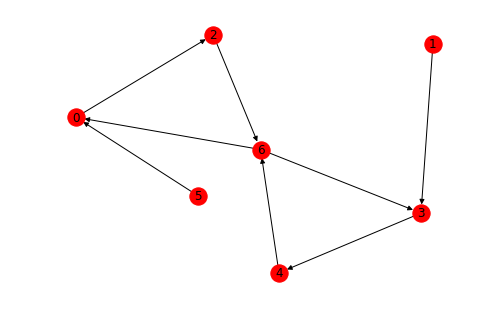

In [40]:
nx.draw(lg.to_networkx(), with_labels=True)